In [13]:
import pandas as pd
from maxentep import MetaModel, traj_quantile, patch_quantile, contact_infection_func, reweight_laplace
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')

In [2]:
# load mobility matrix
data = pd.read_csv('trajectories/nys_commuting_counties.csv', index_col = 0).values
data = [i / np.sum(i) for i in data]
R = np.array(data)
M = R.shape[0]
np.sum(R, axis=0)

array([3.04470101, 0.63298709, 0.65432751, 1.5175129 , 0.78085325,
       0.6341433 , 0.87459994, 1.00571173, 0.68504912, 1.01402755,
       0.63915968, 0.65825195, 0.66197261, 1.04407087, 2.80167096,
       0.80280225, 0.83361601, 0.67170434, 0.66538914, 0.48316792,
       0.5704564 , 0.52324962, 1.10463661, 1.22121747, 0.52581269,
       0.58765684, 0.50016525, 3.22377082, 0.69175819, 1.20546935,
       4.12656194, 0.67824499, 1.75265207, 2.67871074, 1.18177785,
       1.11429053, 0.44422598, 0.63481357, 0.87829422, 0.30881013,
       1.04058779, 0.68213382, 0.38948335, 0.74921793, 0.97165063,
       1.27478184, 0.9820337 , 0.50643875, 0.39695896, 0.53155178,
       1.06668606, 1.25653031, 0.60235276, 0.41815181, 1.51938207,
       0.82304881, 0.99505599, 0.47844257, 0.57760229, 1.59708697,
       0.55656234, 0.52596506])

In [3]:
# compartment parameters
N = 100
C = 4
T = np.zeros((N,C,C))
dist = lambda : ss.beta.rvs(1, 100)
for i in range(N):
    Ti = np.zeros((C,C))
    Ti[0,1] = dist()
    Ti[0,2] = dist()
    Ti[1,3] = dist()
    Ti[2,3] = dist()
    # get what leaves
    np.fill_diagonal(Ti, 1 - np.sum(Ti, axis=1))
    T[i] = Ti
print(T[0])
print([1,0,0,0] @ T[0])

[[0.96433809 0.00577156 0.02989036 0.        ]
 [0.         0.9899233  0.         0.0100767 ]
 [0.         0.         0.99408901 0.00591099]
 [0.         0.         0.         1.        ]]
[0.96433809 0.00577156 0.02989036 0.        ]


In [4]:
f = [0.8,0,0,0]
for i in range(3):
    f = f @ T[0]
    #f = np.clip(f, 0,1)
    #f /= np.sum(f)
    print(f, np.sum(f))

[0.77147047 0.00461724 0.02391229 0.        ] 0.8
[7.43958356e-01 9.02330206e-03 4.68304703e-02 1.87871839e-04] 0.8
[7.17427377e-01 1.32261737e-02 6.87908379e-02 5.55611324e-04] 0.8


In [5]:
# starting fractions
start = np.zeros((N, M, C))
# pick 2 starting patches
seeds = [[0, 1]]
for i in range(N):
    for j in seeds:#np.random.randint(0, M, size=2):
        start[i,j,0] = ss.beta.rvs(1, 100)

In [6]:
#tf.debugging.enable_check_numerics()
model = MetaModel(start, np.tile(R[np.newaxis,:,:], [N,1,1]), T, contact_infection_func(tf.constant([0.1 for _ in range(N)])))
trajs = model.run(1000)

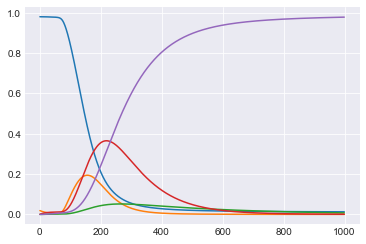

In [7]:
plt.plot(trajs[6,:,0,:])
plt.show()

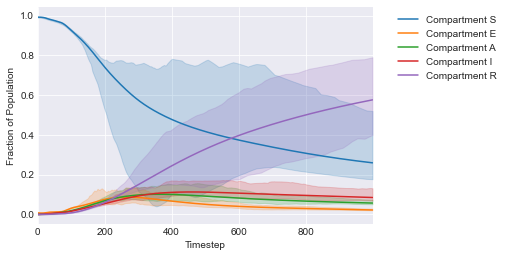

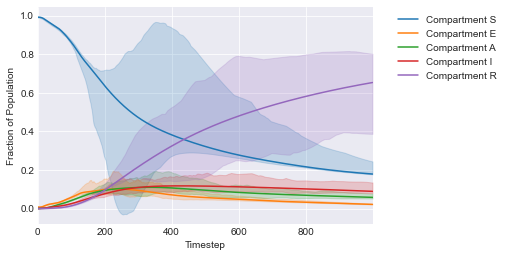

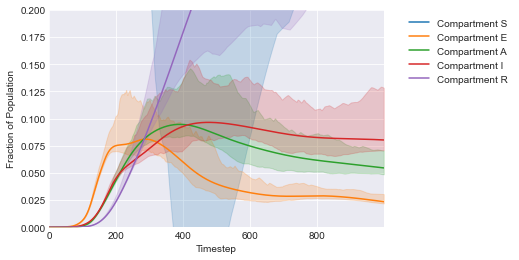

In [38]:
traj_quantile(trajs[:,:,0,:], names=['S', 'E', 'A', 'I', 'R'], plot_means=True)
plt.show()
traj_quantile(trajs[:,:,1,:], names=['S', 'E', 'A', 'I', 'R'], plot_means=True)
plt.show()
traj_quantile(trajs[:,:,2,:], names=['S', 'E', 'A', 'I', 'R'], plot_means=True)
plt.ylim(0,0.2)
plt.show()

In [116]:
ITERS = 25000
restraints = [
    [0.4, 0, 250, 0, 0],
    [0.12,0.05,200,2,1],
    [0.8, 0.1,900, 1, 4],
    [0.6, 0, 250, 34, 4],
    [0.4, 0, 250, 24, 0],
             ]
restraints = restraints
fit = np.empty((ITERS, len(restraints)))
all_lambdas = np.empty((ITERS, len(restraints)))
scales = []
avg_N = ITERS // 5
avg_weights = np.zeros(( avg_N, trajs.shape[0]))
def callback(i, weights, lambdas, e_gk, agreement, scale):
    all_lambdas[i, :] = lambdas
    fit[i, :] = e_gk
    scales.append(scale)
    if i >= ITERS - avg_N:
        avg_weights[i - ITERS + avg_N,:] = weights
final_weights, proc_restraints = reweight_laplace(trajs, restraints, iter=ITERS, callback=callback, learning_rate=2)
weights = np.mean(avg_weights, axis=0)

[ 0.08296621  0.36296621 -0.3170338  -0.11703381  0.08296621]


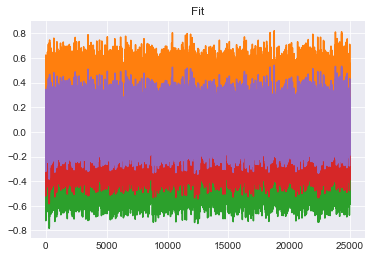

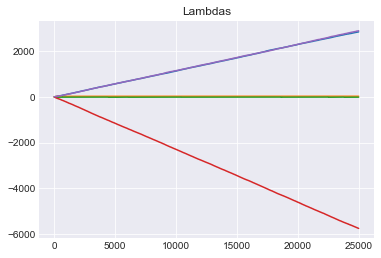

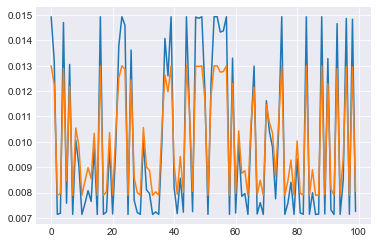

In [117]:
print(fit[-1])
plt.figure()
plt.title('Fit')
plt.plot(fit)
plt.show()

plt.figure()
plt.title('Lambdas')
plt.plot(all_lambdas)
plt.show()

plt.plot(weights)
plt.plot(final_weights)
plt.show()

Plotting 62 patches in a 7 x 9 grid


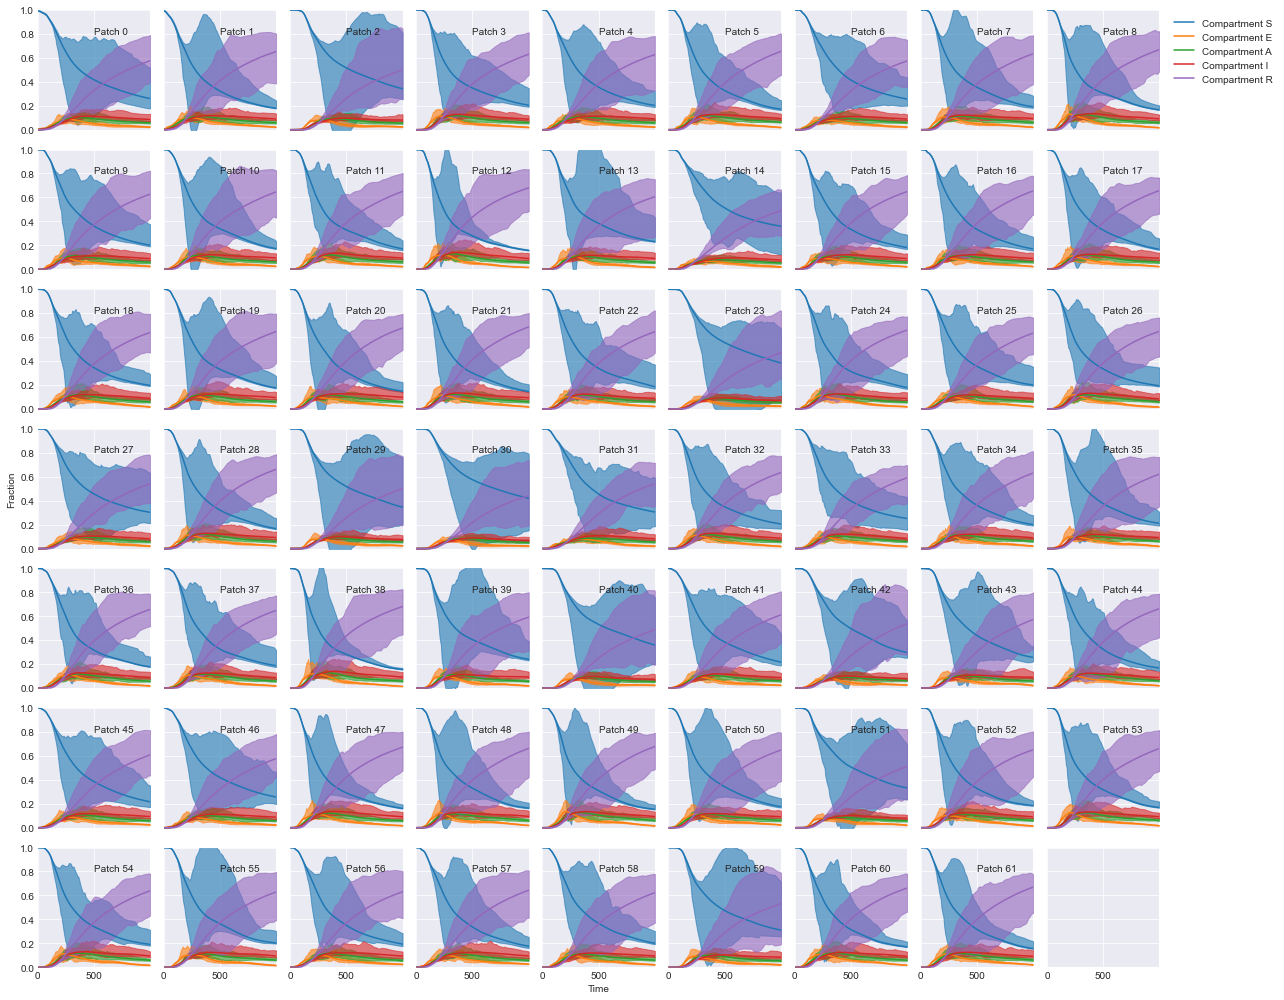

In [119]:
patch_quantile(trajs, figsize=(18, 14), alpha=0.6, names=['S', 'E', 'A', 'I', 'R'])
plt.show()

Plotting 62 patches in a 7 x 9 grid


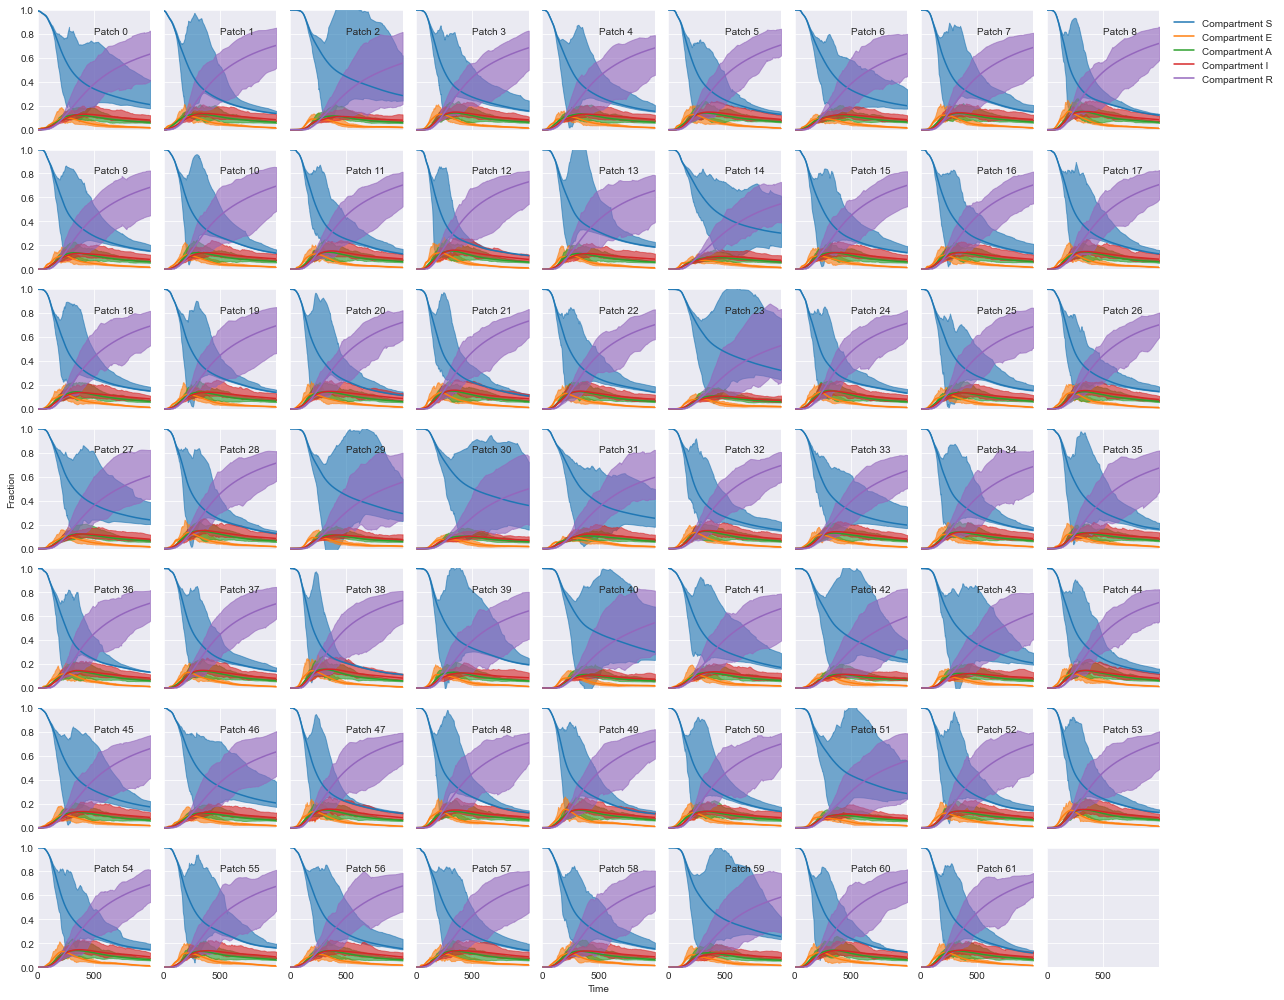

In [120]:
patch_quantile(trajs, weights=weights, figsize=(18, 14), alpha=0.6, names=['S', 'E', 'A', 'I', 'R'])
plt.show()

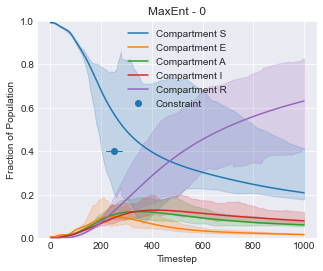

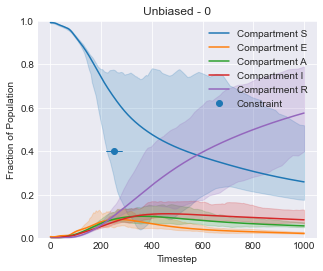

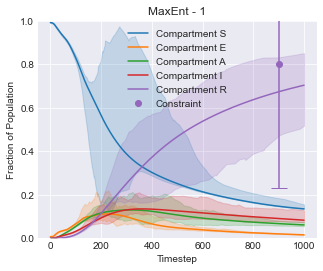

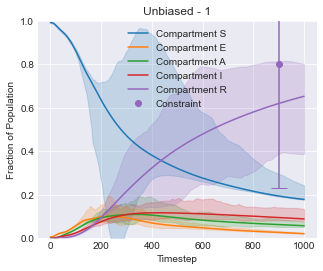

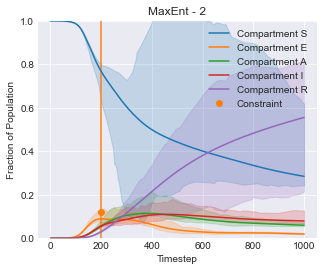

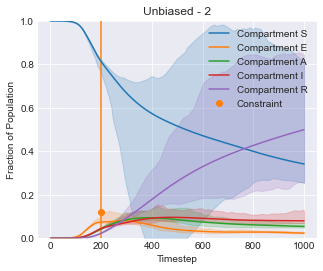

In [118]:
for p in [0,1,2]:
    plt.figure(figsize=(5,4))
    plt.title(f'MaxEnt - {p}')
    traj_quantile(trajs[:,:,p,:], weights, add_legend=False, names=['S', 'E', 'A', 'I', 'R'])
    for i, (pr, r) in enumerate(zip(proc_restraints, restraints)):    
        if r[3] == p:
            plt.plot(r[2], r[0], 'o', color=f'C{r[-1]}', label='Constraint')
            plt.errorbar(r[2], r[0], yerr=pr.prior.expected(all_lambdas[-1][i]), color=f'C{r[-1]}', capsize=8)
    plt.legend(loc='best')
    plt.ylim(0,1)
    plt.show()
    plt.figure(figsize=(5,4))
    plt.title(f'Unbiased - {p}')
    traj_quantile(trajs[:,:,p,:], add_legend=False, names=['S', 'E', 'A', 'I', 'R'])
    for i, (pr, r) in enumerate(zip(proc_restraints, restraints)):    
        if r[3] == p:
            plt.plot(r[2], r[0], 'o', color=f'C{r[-1]}', label='Constraint')
            plt.errorbar(r[2], r[0], yerr=pr.prior.expected(all_lambdas[-1][i]), color=f'C{r[-1]}', capsize=8)
    plt.legend(loc='best')
    plt.ylim(0,1)
    plt.show()